# Backtesting 

### MGMT 638: Data-Driven Investments: Equity
### Kerry Back, Rice University

<a target="_blank" href="https://colab.research.google.com/github/kerryback/mgmt638/blob/main/notebooks/11-backtest.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Read data

- Penny stocks have been eliminated
- Data includes both large caps and small caps.  You can filter to small caps if you want.
- Filter to your sector.

In [3]:
import pandas as pd

url = "https://www.dropbox.com/s/lm4v48d51g64l0f/data-2023-11-29.csv?dl=1"
df = pd.read_csv(url)

In [4]:
# uncomment and execute the following to filter to small caps

"""    
df["rnk"] = df.groupby("date", group_keys=False).marketcap.rank(
    ascending=False, 
    method="first"
)
df = df[(df.rnk>1000) & (df.rnk<=3000)]
df = df.drop(columns=["rnk"])
"""

'    \ndf["rnk"] = df.groupby("date", group_keys=False).marketcap.rank(\n    ascending=False, \n    method="first"\n)\ndf = df[(df.rnk>1000) & (df.rnk<=3000)]\ndf = df.drop(columns=["rnk"])\n'

In [5]:
sector = "Healthcare"
df = df[df.sector==sector]

## Define model and target

- Current code uses max_depth=4 and n_estimators=200
- Two possible targets: return in excess of the median or rank of the return.
- Comment one of them out.

In [6]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(max_depth=4, n_estimators=200)


df["target"] = df.groupby("date", group_keys=False).ret.apply(
    lambda x: 100 * (x-x.median())
)

""" 
# could use this instead

df["target"] = df.groupby("date", group_keys=False).ret.apply(
    lambda x: 100 * x.rank(pct=True)
)
"""



' \n# could use this instead\n\ndf["target"] = df.groupby("date", group_keys=False).ret.apply(\n    lambda x: 100 * x.rank(pct=True)\n)\n'

## Define predictors (features)

- Leaving out interactions with market volatility, because they didn't seem to make much difference.

In [7]:
features = [
    "marketcap", 
    "pb", 
    "mom", 
    "volume", 
    "volatility", 
    "roe", 
    "accruals",
    "agr"
]
features.sort()

## Define training dates and training windows

- Start training once we have three years of data.
- Specify num_years_for_training $\ge 3$ as the number of years of past data to train on in each iteration of the backtesting loop.

In [8]:
num_years_for_training = 5

In [9]:
dates = list(df.date.unique())
dates.sort()
train_dates = dates[156::52]  # once per year starting after three years

past_dates = {}               # dates on which to train for each training date
future_dates = {}             # dates for which to predict for each training date
for date in train_dates:
    start_index = dates.index(date) - 52*num_years_for_training
    start_index = start_index if start_index >= 0 else 0
    past_dates[date] = dates[start_index:dates.index(date)]
    if date < train_dates[-1]:
        future_dates[date] = dates[dates.index(date):(dates.index(date)+52)]
    else:
        future_dates[date] = dates[dates.index(date):]

## Run the loop

In [10]:
new_data = None
for date in train_dates:
    past = past_dates[date]
    past = df[df.date.isin(past)]
    future = future_dates[date]
    future = df[df.date.isin(future)]
    forest.fit(X=past[features], y=past.target)
    predictions = forest.predict(X=future[features])
    predictions = pd.DataFrame(predictions)
    predictions.columns = ["predict"]
    for col in ["ticker", "date"]:
        predictions[col] = future[col].to_list()
    new_data = pd.concat((new_data, predictions))
    
df = df.merge(new_data, on=["ticker", "date"], how="inner")

In [11]:
future.date.max()

'2023-11-17'

## Calculate portfolio returns

- Specify how many stocks you want to hold in each (long or short) portfolio

In [12]:
numstocks = 50

In [13]:
df["rnk_long"] = df.groupby("date", group_keys=False).predict.rank(
    ascending=False,
    method="first"
)
df["rnk_short"] = df.groupby("date", group_keys=False).predict.rank(
    ascending=True,
    method="first"
)


longs = df[df.rnk_long<=numstocks]
shorts = df[df.rnk_short<=numstocks]

In [14]:
long_ret = longs.groupby("date").ret.mean()
short_ret = shorts.groupby("date").ret.mean()
print(f"mean annualized long return is {52*long_ret.mean():.2%}")
print(f"mean annualized short return is {52*short_ret.mean():.2%}")

mean annualized long return is 24.04%
mean annualized short return is -24.73%


## Analyze fitted model on most recent data

In [15]:
present = future[future.date==future.date.max()]
medians = present[features].median()
medians = pd.DataFrame(medians).T

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

def predict1(char):
    data = medians.copy()
    grid = np.linspace(
        present[char].quantile(0.01), 
        present[char].quantile(0.99), 
        100
    )
    predictions = []
    for x in grid:
        data[char] = x
        prediction = forest.predict(X=data).item()
        predictions.append(prediction)
    return grid, predictions

In [17]:
def predict2(char1, char2):
    data = medians.copy()
    grid1 = np.linspace(
        present[char1].quantile(0.005), 
        present[char1].quantile(0.995), 
        20
    )
    grid2 = np.linspace(
        present[char2].quantile(0.01), 
        present[char2].quantile(0.99), 
        20
    )
    grid1, grid2 = np.meshgrid(grid1, grid2)
    predictions = np.empty(grid1.shape)
    for i in range(20):
        for j in range(20):
            data[char1] = grid1[i, j]
            data[char2] = grid2[i, j]
            predictions[i, j] = forest.predict(data)
    return grid1, grid2, predictions

### Feature importances

In [18]:
importances = pd.Series(forest.feature_importances_, index=features)
importances.sort_values(ascending=False).round(3)

pb            0.427
marketcap     0.165
volume        0.122
agr           0.076
mom           0.071
volatility    0.069
accruals      0.042
roe           0.027
dtype: float64

### Vary one characteristic at a time and plot

- Specify which characteristic

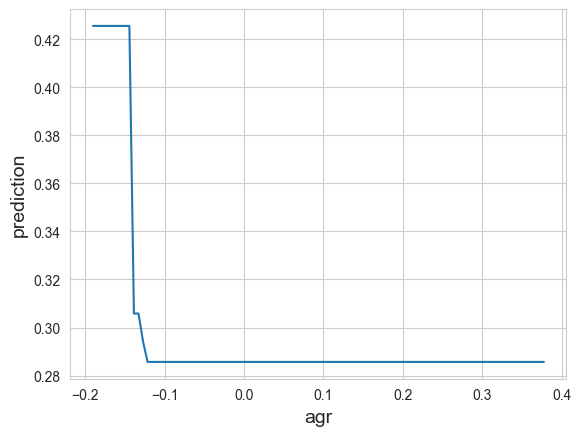

In [19]:
char = "agr"

grid, predictions = predict1(char)
plt.plot(grid, predictions)
plt.xlabel(char,  fontdict={"size": 14})
plt.ylabel("prediction",  fontdict={"size": 14})
plt.show()

### Vary two characteristics at a time and plot

- Specify which characteristics

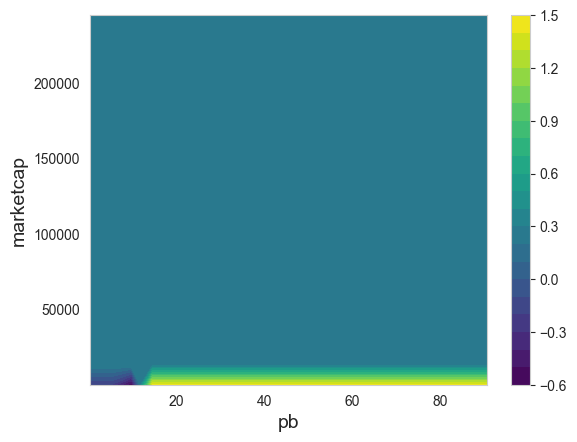

In [20]:
char1 = "pb"  
char2 = "marketcap"  

grid1, grid2, predictions = predict2(char1, char2)
contour = plt.contourf(grid1, grid2, predictions, 20, cmap="viridis")
cbar = plt.colorbar(contour)
plt.xlabel(char1, fontdict={"size": 14})
plt.ylabel(char2, fontdict={"size": 14})
plt.show()

## Analyze backtest returns

In [22]:
from pandas_datareader.famafrench import get_available_datasets as gad  
gad()

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily',
 'Portfolios_Formed_on_ME',
 'Portfolios_Formed_on_ME_Wout_Div',
 'Portfolios_Formed_on_ME_Daily',
 'Portfolios_Formed_on_BE-ME',
 'Portfolios_Formed_on_BE-ME_Wout_Div',
 'Portfolios_Formed_on_BE-ME_Daily',
 'Portfolios_Formed_on_OP',
 'Portfolios_Formed_on_OP_Wout_Div',
 'Portfolios_Formed_on_OP_Daily',
 'Portfolios_Formed_on_INV',
 'Portfolios_Formed_on_INV_Wout_Div',
 'Portfolios_Formed_on_INV_Daily',
 '6_Portfolios_2x3',
 '6_Portfolios_2x3_Wout_Div',
 '6_Portfolios_2x3_weekly',
 '6_Portfolios_2x3_daily',
 '25_Portfolios_5x5',
 '25_Portfolios_5x5_Wout_Div',
 '25_Portfolios_5x5_Daily',
 '100_Portfolios_10x10',
 '100_Portfolios_10x10_Wout_Div',
 '100_Portfolios_10x10_Daily',
 '6_Portfolios_ME_OP_2x3',
 '6_Portfolios_ME_OP_2x3_Wout_Div',
 '6_Portfolios_ME_OP_2x3_daily',
 '25_Portfolios_ME_OP_5x5',
 '25_Portf

In [27]:
from pandas_datareader import DataReader as pdr 
famafrench = pdr(
    "F-F_Research_Data_5_Factors_2x3_daily",
    "famafrench",
    start=2010
)[0] / 100  

famafrench.index.name = "date"
famafrench = famafrench.reset_index()
famafrench["year"] = famafrench.date.apply(lambda x: x.isocalendar()[0])
famafrench["week"] = famafrench.date.apply(lambda x: x.isocalendar()[1])

ff = None
for col in ["Mkt-RF", "SMB", "HML", "CMA", "RMW"]:
    ser = famafrench.groupby(["year", "week"], group_keys=True)[col].apply(
        lambda x: (1+x).prod() - 1
    )
    ser.name = col
    ff = pd.concat((ff, ser), axis=1)
ff["date"] = famafrench.groupby(["year", "week"], group_keys=True).date.last()
ff = ff.reset_index(drop=True)
ff = ff.set_index("date")

In [29]:
famafrench.head()

,date,Mkt-RF,SMB,HML,RMW,CMA,RF,year,week
0,2010-01-04,0.0169,0.0079,0.0113,-0.0017,0.0021,0.0,2010,1
1,2010-01-05,0.0031,-0.0041,0.0124,-0.0019,0.0019,0.0,2010,1
2,2010-01-06,0.0013,-0.0013,0.0057,-0.0005,0.0020,0.0,2010,1
3,2010-01-07,0.0040,0.0025,0.0098,-0.0069,0.0022,0.0,2010,1
4,2010-01-08,0.0033,0.0032,0.0001,0.0022,-0.0037,0.0,2010,1


In [28]:
ff

,Mkt-RF,SMB,HML,CMA,RMW
date,,,,,
2010-01-08,0.028848,0.008185,0.039871,0.004495,-0.008791
2010-01-15,-0.009111,-0.001216,-0.015084,0.004592,0.006377
2010-01-22,-0.035854,0.005176,-0.019711,-0.005794,-0.002325
2010-01-29,-0.017002,-0.007889,0.000763,0.002701,-0.007130
2010-02-05,-0.008056,-0.007780,-0.000336,0.011311,0.001662
...,...,...,...,...,...
2023-09-01,0.027426,0.007591,0.006482,-0.008975,-0.001711
2023-09-08,-0.015232,-0.027381,-0.006127,-0.003705,-0.006898
2023-09-15,-0.002844,-0.004356,0.013786,0.000373,0.005456


In [26]:
famafrench.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2023-09-18', '2023-09-19', '2023-09-20', '2023-09-21',
               '2023-09-22', '2023-09-25', '2023-09-26', '2023-09-27',
               '2023-09-28', '2023-09-29'],
              dtype='datetime64[ns]', name='Date', length=3459, freq=None)

In [21]:
long_ret

date
2014-01-10    0.021073
2014-01-17    0.114359
2014-01-24    0.059584
2014-01-31   -0.046854
2014-02-07   -0.021150
                ...   
2023-10-20   -0.034435
2023-10-27   -0.053900
2023-11-03    0.090240
2023-11-10   -0.052940
2023-11-17    0.065973
Name: ret, Length: 515, dtype: float64

In [ ]:
import pandas as pd 
import statsmodels.formula.api as smf

df = pd.concat((return_monthly, mkt, rf), axis=1).dropna()
df.columns = ["ret", "mkt", "rf"]
df[["ret_rf", "mkt_rf"]] = df[["ret", "mkt"]].subtract(df.rf, axis=0)

result = smf.ols("ret_rf ~ mkt_rf", df).fit()